In [1]:
import h5py as h5
from math import sqrt,pi
import numpy as np
import matplotlib.pyplot as plt
from plot_settings import plotparams
from kinematic_functions import zed#qsq,k,wl
from BGL import phi#,blaschke
from scipy.optimize import minimize_scalar
import scipy
import time
import masses
from tqdm import tqdm
from numba import jit

In [2]:
# light mesons
mpi=(2*0.13957061+0.1349770)/3 # PDG2018
mK=(0.493677+0.497611)/2       # PDG2018

# B mesons
mB=(5.27933+5.27964)/2
mBstar= 5.32470
mBs=5.36682
mBstar0plus=5.63

tp=(mBs+mK)**2
tm=(mBs-mK)**2 # = qsqmax
tcut=(mB+mpi)**2
t0=tcut-sqrt(tcut*(tcut-tm))# D mesons

etaBsK=1
chi1minusBsK=6.03e-4
chi0plusBsK=1.48e-2
fpluspoles=np.array([mBstar])
fzeropoles=np.array([])

zmax=zed(0,tcut,t0)

# z-values for pole positions
zpluspole=zed(mBstar**2,tcut,t0)
#zzeropole=zed(mBstar0plus**2,tcut,t0) # mBstar0plus is above threshold
#nplus=2 # number of input values for f+
#nzero=3 # number of input values for f0
#qsqmin='17.50' # (17.50,18.,00,18.50,19.00)
path=''


In [3]:
#@jit(nopython=True)
def z(t):
    return zed(t,tcut,t0)

In [4]:
polevalszero = []
polevalsplus = [5.324700**2]
chi0plus = 1.48e-02
chi1minus = 6.03e-04
chiplus = chi1minus
chizero = chi0plus
mKphys		= masses.mK
mBsphys		= masses.mBs
eta = 1
tstar = 29.349571
t0 = 16.505107
tplus = 34.368484
tminus = 23.728356

In [5]:
(mKphys+mBsphys)**2

34.36848415129599

In [6]:
alpha = np.arctan((2*np.sqrt(tp-tcut)*np.sqrt(tcut-t0))/(2*tcut - tp - t0))
cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
sin_2alpha = np.sin(2*alpha)

f0_norm = 1/np.sqrt(2*alpha)
f1_norm = (2*alpha - 2*sin_alpha**2 /alpha)**(-.5)
f2_b = (sin_alpha-sin_alpha**2 *cos_alpha/alpha)/(sin_alpha**2/alpha - alpha)
f2_c = -(sin_2alpha + 2*f2_b*sin_alpha)/(2*alpha)
f2_norm = (2*alpha*(1+f2_b**2+f2_c**2) + (1+f2_c)*f2_b*4*sin_alpha + f2_c*2*sin_2alpha)**(-.5)

In [7]:
alpha

1.1173369938453133

In [8]:
def alt_polynomial(t,n):
    if n == 0:
        return 1*f0_norm
    if n == 1:
        return f1_norm*(z(t)-(sin_alpha)/alpha)
    if n == 2:
        return f2_norm*(z(t)**2 + z(t)*f2_b + f2_c)

In [9]:
def ff_E(Evec,pole,coeff):
  # construct ff from HMChPT in continuum limit
  return [1./(E+pole)*np.sum([E**i*coeff[i] for i in range(len(coeff))]) for E in Evec]

In [10]:
def cov_ff_p0(Evec_p,Evec_0,C,Np,N0,pole_p,pole_0):
  # construct covariance matrix for ff from HMChPT in continuum limit
  Y_E_p_vec   	= lambda E_p: np.r_[ np.array([1./(E_p+pole_p)*E_p**i for i in range(Np)])]
  Y_E_0_vec   	= lambda E_0: np.r_[ np.array([1./(E_0+pole_0)*E_0**i for i in range(N0)])]
  Cpp		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np,:Np],Y_E_p_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_p])
  C00		= np.array([[np.dot(Y_E_0_vec(E1),np.dot(C[Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_0] for E2 in Evec_0])
  Cp0		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_0])
  M0		= np.r_['-1',Cpp  ,Cp0.T]
  M1		= np.r_['-1',Cp0  ,C00  ]
  M		= np.r_[M0,M1]
  return M

In [11]:
def phiplus(t,chi = chiplus):
    #chi = 1
    K = 48*np.pi
    a = 3
    b = 2
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    val = np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)
    for i in range(len(polevalsplus)):
        val *= (z(t)-z(polevalsplus[i]))/(1-np.conjugate(z(polevalsplus[i]))*z(t))
    return val

In [12]:
def phizero(t,chi = chizero):
    #chi = 1
    K = 16*np.pi/(tplus*tminus)
    a = 1
    b = 1
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    val = np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)
    for i in range(len(polevalszero)):
        val *= (z(t)-z(polevalszero[i]))/(1-np.conjugate(z(polevalszero[i]))*z(t))
    return val

In [13]:
def phi_ff(t,ff):
    if ff == 0:
        return phizero(t)
    elif ff == 1:
        return phiplus(t)

In [14]:
# def Phi_n(n,z):
#     ans = 1
#     if n == 0:
#         return ans
#     if n > 0:
#         for n in range(1,n):
            

In [15]:
def zfunction(t,a,ff,functtype = "zfit"):
    #print(a)
    if functtype  == "zfit":
        if ff == 0:
            tempsum = 0
            for n,an in enumerate(a):
                tempsum += 1/phi_ff(t,ff)*an*z(t)**n #(1-t/(mBstar**2))*an*z(t)**n
            return tempsum
        elif ff == 1:
            tempsum = 0
            #K = len(a)
            #print(K)
            for n,an in enumerate(a):
                #print(n,an)
                tempsum += 1/phi_ff(t,ff)*an*z(t)**n #BCL: (1-t/(mBstar**2))*an*(z(t)**n - (-1)**(n-K)*n/K *z(t)**K)
            return tempsum
        else:
            print("invalid ff value")
    if functtype  == "altfit":
        
        if ff == 0 or 1:
            tempsum = 0
            for n,an in enumerate(a):
                tempsum += an*alt_polynomial(t,n) #(1-t/(mBstar**2))*an*z(t)**n
            return tempsum/phi_ff(t,ff)
        else:
            print("invalid ff value")

In [16]:
def ffs_from_input_q2(zerotlist,plustlist,nsamples = 0):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)

    qsqinputl = np.array(plustlist + zerotlist)


    zinputl=zed(qsqinputl,tcut,t0)

    npts=len(bskpts)
    bskptslbls=[char for char in nplus*'+'+nzero*'0']

    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))

    # input f+ and f0 values
    tpin=qsqinputl[:nplus]
    zpin=zed(tpin,tcut,t0)
    fpin=bskpts[:nplus]
    dfpin=dbsk[:nplus]
    tzin=qsqinputl[nplus:]
    zzin=zed(tzin,tcut,t0)
    fzin=bskpts[nplus:]
    dfzin=dbsk[nplus:]
    nppts=len(zpin)
    nzpts=len(zzin)

    fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
    fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
    zero_ffs = np.array((tzin,fzin))
    plus_ffs = np.array((tpin,fpin))
    return zero_ffs,plus_ffs,bskcov

In [17]:
ffs_from_input_q2([15,20],[15,17,20])

(array([[15.        , 20.        ],
        [ 0.38879949,  0.61208472]]),
 array([[15.        , 17.        , 20.        ],
        [ 0.68235664,  0.92042411,  1.48509642]]),
 array([[0.00100023, 0.00102579, 0.00108644, 0.00034855, 0.00023526],
        [0.00102579, 0.00107984, 0.00120803, 0.00034109, 0.00026642],
        [0.00108644, 0.00120803, 0.00149642, 0.0003234 , 0.00034031],
        [0.00034855, 0.00034109, 0.0003234 , 0.00042774, 0.0001226 ],
        [0.00023526, 0.00026642, 0.00034031, 0.0001226 , 0.00013575]]))

In [18]:
nzero = 3
nplus = 2
inputs = [1,2,3,4,5,6]
(inputs[0:nzero],inputs[nzero:-1])


([1, 2, 3], [4, 5])

In [19]:
def function_to_minimise(inputs,inputq2,inputffs,invcov,functtype = "zfit"):#, lam
    #make sure to define:inputq2,inputffs,inputcov,functtype = "zfit" before this
    coefficients = (inputs[0:nzero],inputs[nzero:nzero+nplus])
    ssum = 0
    fflist = [zfunction(q2,coefficients[0],0,functtype) for q2 in inputq2[0]] + [zfunction(q2,coefficients[1],1,functtype) for q2 in inputq2[1]]
    
    for i in range(len(fflist)):
        for j in range(len(fflist)):
            ssum += (fflist[i]-inputffs[i])*invcov[i,j]*(fflist[j]-inputffs[j])
    return ssum# + lam*(zfunction(0,coefficients[0],0)-zfunction(0,coefficients[1],1))**2

In [20]:
def zfitit(inputq2,nboot,functtype = "zfit"):
    ffdata = ffs_from_input_q2(inputq2[0],inputq2[1])
    resampledffdata = np.random.multivariate_normal(np.append(ffdata[0][1],ffdata[1][1]),ffdata[2],size=nboot)
    nzero = len(inputq2[0])
    nplus = len(inputq2[1])
    resampledffs = (resampledffdata[:,0:nzero],resampledffdata[:,nzero:])#,dtype = object
    invcov = np.linalg.inv(ffdata[2])
    initial_guess = scipy.optimize.minimize(function_to_minimise,np.linspace(0.1,0.1,nzero+nplus),args = (inputq2,np.append(ffdata[0][1],ffdata[1][1]),invcov),method='trust-constr',constraints=cons).x
    outputcoeffs = np.zeros((nzero+nplus,nboot))
    if functtype == "zfit":
        constype = cons
    elif functtype == "altfit":
        constype = cons_alt
    for i in tqdm(range(np.shape(resampledffdata)[0])):
        #print(i)
        outputcoeffs[:,i] = scipy.optimize.minimize(function_to_minimise,initial_guess,args = (inputq2,resampledffdata[i,:],invcov,functtype),method='trust-constr',constraints=constype).x
    return outputcoeffs

In [21]:
inputq2 = np.array(([15,17,20],[15,20]),dtype=object)
nzero = 3 #len(inputq2[0])#+1
nplus = 2 #len(inputq2[1])#+1
genffdata = ffs_from_input_q2(inputq2[0],inputq2[1])
inputffs = np.append(genffdata[0][1],genffdata[1][1]) #temporary (havent been resampled yet)
print(inputffs)
inputcov = genffdata[2]
#lam = 10**3
invcov = np.linalg.inv(inputcov)
#cons = [{'type': 'ineq', 'fun': lambda inlist: zfunction(0,inlist[:nzero],0)-zfunction(0,inlist[nzero:nzero+nplus],1)},
#        {'type': 'ineq', 'fun': lambda inlist: -zfunction(0,inlist[:nzero],0)+zfunction(0,inlist[nzero:nzero+nplus],1)}]
cons = [{'type': 'eq', 'fun': lambda inlist: zfunction(0,inlist[:nzero],0)-zfunction(0,inlist[nzero:nzero+nplus],1)},{'type': 'ineq', 'fun': lambda inlist: 1- sum([inlist[i]**2 for i in range(len(inlist))])}]
scipy.optimize.minimize(function_to_minimise,np.linspace(0.1,0.1,nzero+nplus),args = (inputq2,inputffs,inputcov,"altfit"), method='trust-constr',constraints=cons).x #,bounds = [(-1,1),(-1,1),(-1,1),(-1,1),(-1,1)], ,functtype = "zfit"


[0.38879949 0.46845682 0.61208472 0.68235664 1.48509642]


C:\Users\09cra\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


array([-0.16989614, -0.12108523,  0.04556504, -0.04126728, -0.05150325])

[list([15, 17, 20]) list([15, 20])]
(array([[15.        , 17.        , 20.        ],
       [ 0.38879949,  0.46845682,  0.61208472]]), array([[15.        , 20.        ],
       [ 0.68235664,  1.48509642]]), array([[0.00100023, 0.00108644, 0.00034855, 0.00029113, 0.00023526],
       [0.00108644, 0.00149642, 0.0003234 , 0.00031957, 0.00034031],
       [0.00034855, 0.0003234 , 0.00042774, 0.00028331, 0.0001226 ],
       [0.00029113, 0.00031957, 0.00028331, 0.00020756, 0.00012556],
       [0.00023526, 0.00034031, 0.0001226 , 0.00012556, 0.00013575]]))
0.027761944008949796
[-0.16989614 -0.12108523  0.04556504] [-0.04126728 -0.05150325]


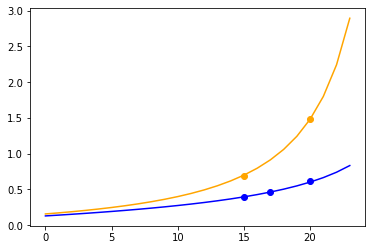

In [22]:
q2rangetoplot = np.linspace(0,23,24)
coefficients = np.array([-0.16989614, -0.12108523,  0.04556504, -0.04126728, -0.05150325])
ffstoplot = ffs_from_input_q2(inputq2[0],inputq2[1])
inputffs = np.append(ffstoplot[0][1],ffstoplot[1][1])
print(inputq2)
print(ffstoplot)
plt.scatter(ffstoplot[0][0],ffstoplot[0][1],color = "blue")
plt.scatter(ffstoplot[1][0],ffstoplot[1][1],color = "orange")
plt.plot(q2rangetoplot, [zfunction(q2,coefficients[:nzero],0,"altfit") for q2 in q2rangetoplot],color = "blue")
plt.plot(q2rangetoplot, [zfunction(q2,coefficients[nzero:nzero+nplus],1,"altfit") for q2 in q2rangetoplot],color = "orange")
print(zfunction(0,coefficients[nzero:nzero+nplus],1,"altfit")-zfunction(0,coefficients[:nzero],0,"altfit"))
print(coefficients[:nzero],coefficients[nzero:nzero+nplus])

In [34]:
inputq2 = np.array(([17,18,20],[17,20]),dtype=object)
nzero = 3 #len(inputq2[0])#+1
nplus = 2 #len(inputq2[1])#+1
genffdata = ffs_from_input_q2(inputq2[0],inputq2[1])
inputffs = np.append(genffdata[0][1],genffdata[1][1]) #temporary (havent been resampled yet)
print(inputffs)
inputcov = genffdata[2]
#lam = 10**3
invcov = np.linalg.inv(inputcov)
#cons = [{'type': 'ineq', 'fun': lambda inlist: zfunction(0,inlist[:nzero],0)-zfunction(0,inlist[nzero:nzero+nplus],1)},
#        {'type': 'ineq', 'fun': lambda inlist: -zfunction(0,inlist[:nzero],0)+zfunction(0,inlist[nzero:nzero+nplus],1)}]
cons = [{'type': 'eq', 'fun': lambda inlist: zfunction(0,inlist[:nzero],0)-zfunction(0,inlist[nzero:nzero+nplus],1)},{'type': 'ineq', 'fun': lambda inlist: 1- sum([inlist[i]**2 for i in range(len(inlist))])}]
cons_alt = [{'type': 'eq', 'fun': lambda inlist: zfunction(0,inlist[:nzero],0,"altfit")-zfunction(0,inlist[nzero:nzero+nplus],1,"altfit")},{'type': 'ineq', 'fun': lambda inlist: 1- sum([inlist[i]**2 for i in range(len(inlist))])}]

scipy.optimize.minimize(function_to_minimise,np.linspace(0.1,0.1,nzero+nplus),args = (inputq2,inputffs,inputcov),method='trust-constr',constraints=cons).x#,bounds = [(-1,1),(-1,1),(-1,1),(-1,1),(-1,1)], ,functtype = "zfit"


[0.46845682 0.5124177  0.61208472 0.92042411 1.48509642]


C:\Users\09cra\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


array([ 0.07880131, -0.12083838,  0.04616671,  0.02113924, -0.02978934])

[list([17, 18, 20]) list([17, 20])]
(array([[17.        , 18.        , 20.        ],
       [ 0.46845682,  0.5124177 ,  0.61208472]]), array([[17.        , 20.        ],
       [ 0.92042411,  1.48509642]]), array([[0.00107984, 0.00120803, 0.00029956, 0.00028379, 0.00026642],
       [0.00120803, 0.00149642, 0.00031957, 0.00032218, 0.00034031],
       [0.00029956, 0.00031957, 0.00020756, 0.0001751 , 0.00012556],
       [0.00028379, 0.00032218, 0.0001751 , 0.00015596, 0.00012802],
       [0.00026642, 0.00034031, 0.00012556, 0.00012802, 0.00013575]]))
-4.679340481761329e-08
[ 0.0745317 -0.3148924  0.1163006] [ 0.01836438 -0.07009019]


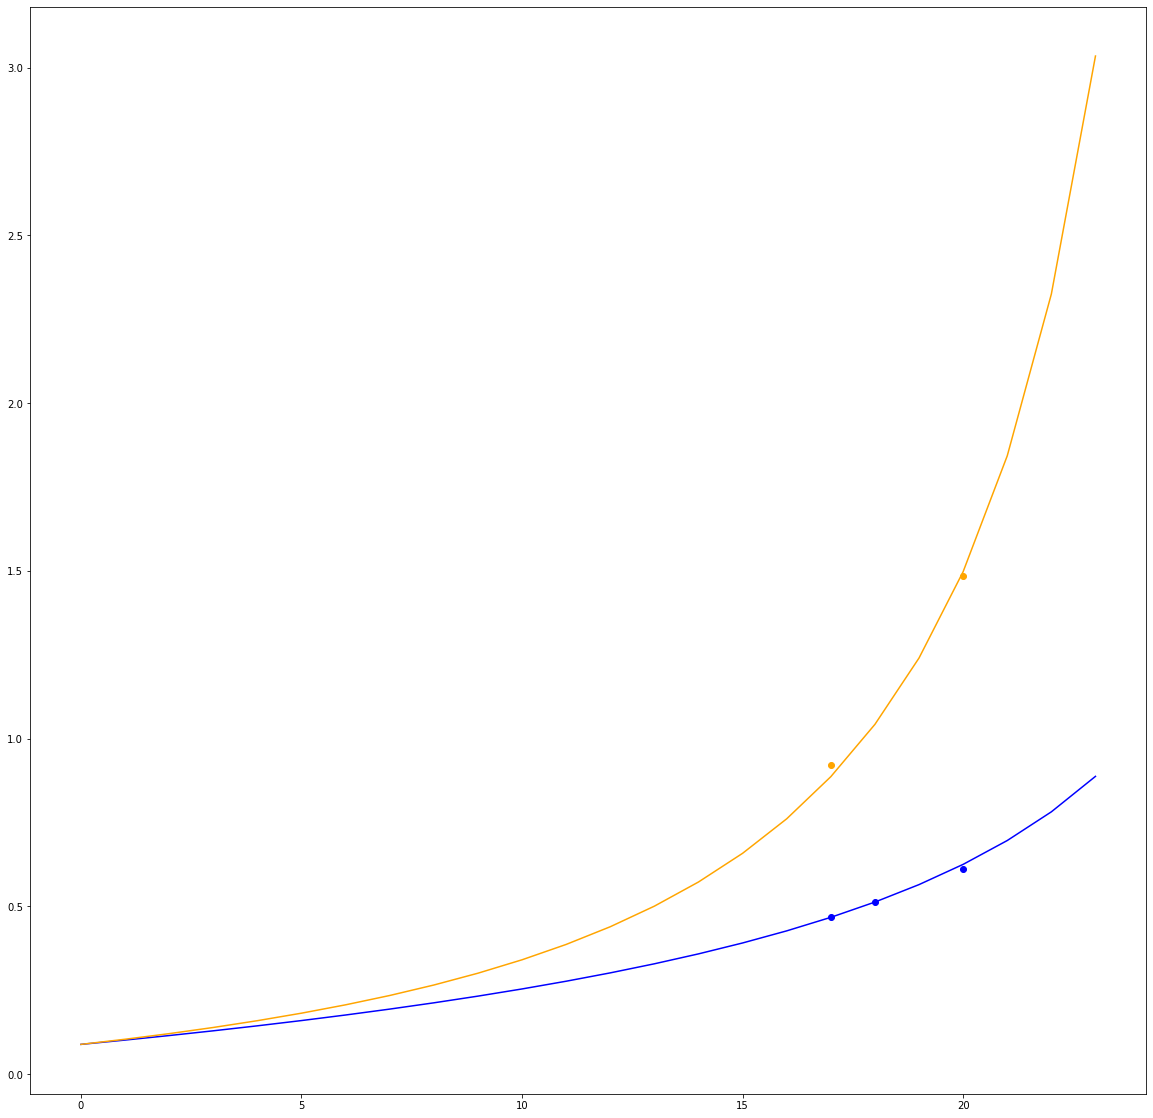

In [35]:
q2rangetoplot = np.linspace(0,23,24)
coefficients = np.array([ 0.0745317 , -0.3148924 ,  0.1163006 ,  0.01836438, -0.07009019])
ffstoplot = ffs_from_input_q2(inputq2[0],inputq2[1])
inputffs = np.append(ffstoplot[0][1],ffstoplot[1][1])
print(inputq2)
print(ffstoplot)
plt.scatter(ffstoplot[0][0],ffstoplot[0][1],color = "blue")
plt.scatter(ffstoplot[1][0],ffstoplot[1][1],color = "orange")
plt.plot(q2rangetoplot, [zfunction(q2,coefficients[:nzero],0) for q2 in q2rangetoplot],color = "blue")
plt.plot(q2rangetoplot, [zfunction(q2,coefficients[nzero:nzero+nplus],1) for q2 in q2rangetoplot],color = "orange")
print(zfunction(0,coefficients[nzero:nzero+nplus],1)-zfunction(0,coefficients[:nzero],0))
print(coefficients[:nzero],coefficients[nzero:nzero+nplus])

In [36]:
ffdata = ffs_from_input_q2(inputq2[0],inputq2[1])
a = np.random.multivariate_normal(np.append(ffdata[1][1],ffdata[0][1]),ffdata[2],size=10)#[:,1]


In [37]:
#inputq2 = np.array(([17.5,19,23],[17.5,23]),dtype=object)
nboot = 200
coarray = zfitit(inputq2,nboot)

C:\Users\09cra\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


In [38]:
#inputq2 = np.array(([17.5,19,23],[17.5,23]),dtype=object)
coarray_alt = zfitit(inputq2,nboot,"altfit")

100%|██████████| 200/200 [05:37<00:00,  1.69s/it]


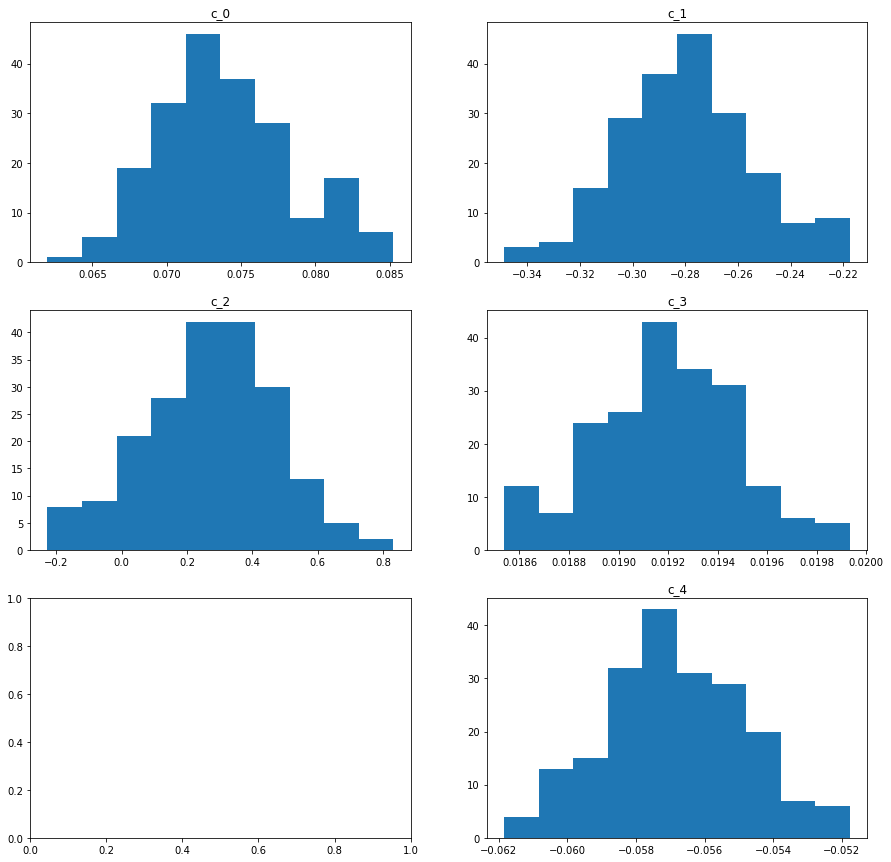

In [39]:
plt.rcParams["figure.figsize"] = (15,15)
fig,axs = plt.subplots(3,2)
#fig.suptitle(r'Bounds at $q^2 = 0$ with randomly generated input form factor $q^2$ values')
axs[0,0].hist(coarray[0,:])
axs[0,0].set_title("c_0")
axs[0,1].hist(coarray[1,:])
axs[0,1].set_title("c_1")
axs[1,0].hist(coarray[2,:])
axs[1,0].set_title("c_2")
axs[1,1].hist(coarray[3,:])
axs[1,1].set_title("c_3")
axs[2,1].hist(coarray[4,:])
axs[2,1].set_title("c_4")
plt.show()

In [40]:
q2rangetoplot = np.linspace(0,23,70)
ffarray = np.zeros((2,len(q2rangetoplot),np.shape(coarray)[1]))
for i,q2 in enumerate(q2rangetoplot):
    for j in range(np.shape(coarray)[1]):
        ffarray[0,i,j] = zfunction(q2,coarray[:nzero,j],0)
        ffarray[1,i,j] = zfunction(q2,coarray[nzero:nzero+nplus,j],1)
sigmabelow = round(np.shape(coarray)[1] * (1-0.6827)/2)
sigmaabove = round(np.shape(coarray)[1] * (1+0.6827)/2)
sorted_ffarray = np.sort(ffarray,2)

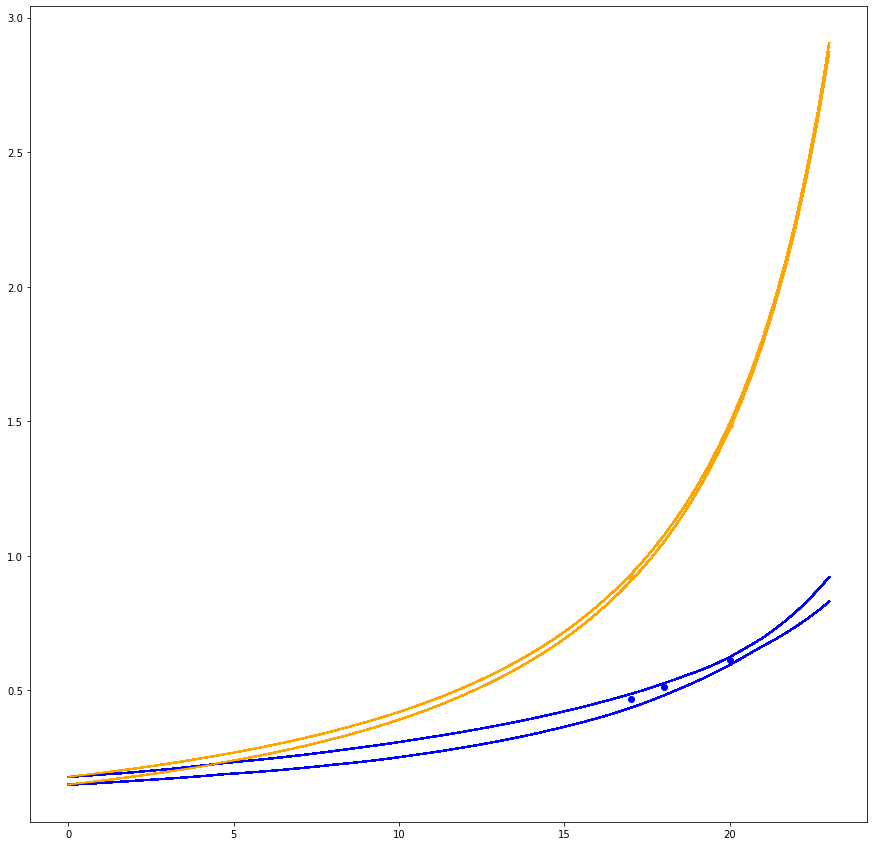

In [41]:
q2rangetoplot = np.linspace(0,23,70)
ffstoplot = ffs_from_input_q2(inputq2[0],inputq2[1])
inputffs = np.append(ffstoplot[0][1],ffstoplot[1][1])
plt.scatter(ffstoplot[0][0],ffstoplot[0][1],color = "blue")
plt.scatter(ffstoplot[1][0],ffstoplot[1][1],color = "orange")
for i in range(np.shape(coarray)[1]):
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[:nzero,i],0) for q2 in q2rangetoplot],color = "blue",alpha=0.005)
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[nzero:nzero+nplus,i],1) for q2 in q2rangetoplot],color = "orange",alpha=0.005)
    plt.plot(q2rangetoplot,[sorted_ffarray[0,q2,sigmabelow] for q2 in range(len(q2rangetoplot))],color = "blue")
    plt.plot(q2rangetoplot,[sorted_ffarray[0,q2,sigmaabove] for q2 in range(len(q2rangetoplot))],color = "blue")
    plt.plot(q2rangetoplot,[sorted_ffarray[1,q2,sigmabelow] for q2 in range(len(q2rangetoplot))],color = "orange")
    plt.plot(q2rangetoplot,[sorted_ffarray[1,q2,sigmaabove] for q2 in range(len(q2rangetoplot))],color = "orange")

In [42]:
q2rangetoplot = np.linspace(0,23,70)
ffarray_alt = np.zeros((2,len(q2rangetoplot),np.shape(coarray_alt)[1]))
for i,q2 in enumerate(q2rangetoplot):
    for j in range(np.shape(coarray_alt)[1]):
        ffarray_alt[0,i,j] = zfunction(q2,coarray_alt[:nzero,j],0,"altfit")
        ffarray_alt[1,i,j] = zfunction(q2,coarray_alt[nzero:nzero+nplus,j],1,"altfit")
sigmabelow_alt = round(np.shape(coarray_alt)[1] * (1-0.6827)/2)
sigmaabove_alt = round(np.shape(coarray_alt)[1] * (1+0.6827)/2)
sorted_ffarray_alt = np.sort(ffarray_alt,2)

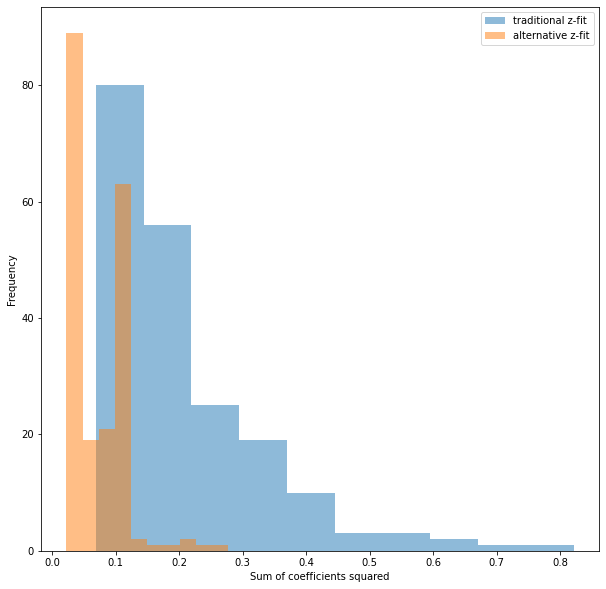

In [43]:
coeff_squared = np.zeros((np.shape(coarray)[1]))
coeff_alt_squared = np.zeros((np.shape(coarray_alt)[1]))

for i in range(np.shape(coarray)[1]):
    coeff_squared[i] = np.sum([coarray[j,i]**2 for j in range(np.shape(coarray)[0])])
for i in range(np.shape(coarray)[1]):
    coeff_alt_squared[i] = np.sum([coarray_alt[j,i]**2 for j in range(np.shape(coarray_alt)[0])])
plt.rcParams["figure.figsize"] = (10,10)
plt.hist(coeff_squared,alpha=0.5,label = "traditional z-fit")
plt.hist(coeff_alt_squared,alpha=0.5,label = "alternative z-fit")
plt.xlabel("Sum of coefficients squared")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [48]:
np.mean(coarray,axis=1)

array([ 0.07400722, -0.27959158,  0.27230031,  0.01919256, -0.0568278 ])

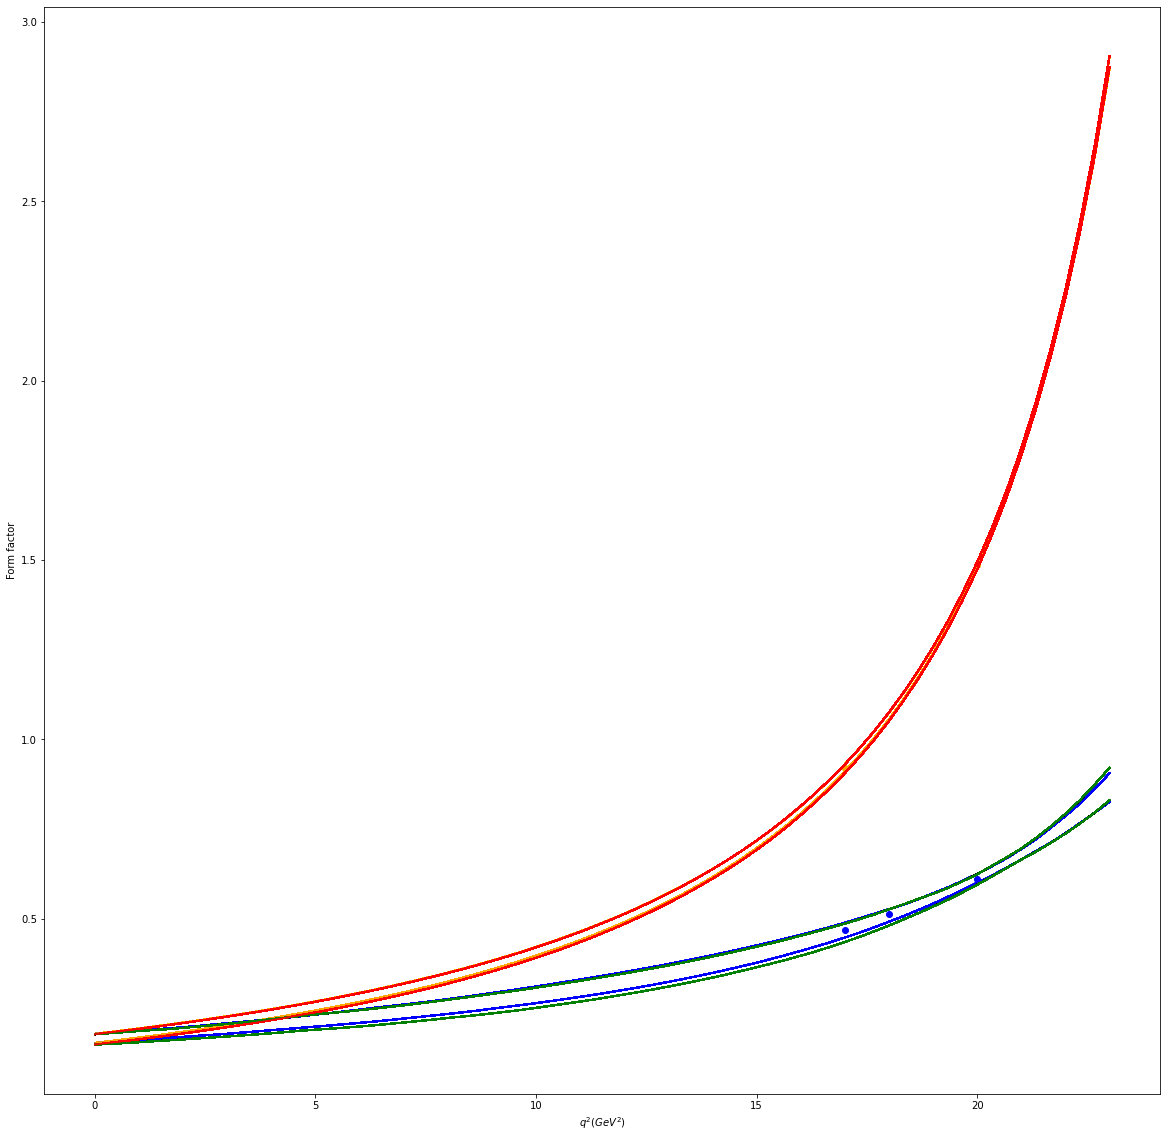

In [44]:
plt.rcParams["figure.figsize"] = (20,20)
q2rangetoplot = np.linspace(0,23,70)
ffstoplot = ffs_from_input_q2(inputq2[0],inputq2[1])
inputffs = np.append(ffstoplot[0][1],ffstoplot[1][1])
plt.scatter(ffstoplot[0][0],ffstoplot[0][1],color = "blue")
plt.scatter(ffstoplot[1][0],ffstoplot[1][1],color = "orange")
plt.xlabel("$q^2 (GeV^2)$")
plt.ylabel("Form factor")
for i in range(np.shape(coarray_alt)[1]):
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[:nzero,i],0) for q2 in q2rangetoplot],color = "blue",alpha=0.005)
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[nzero:nzero+nplus,i],1) for q2 in q2rangetoplot],color = "orange",alpha=0.005)
    plt.plot(q2rangetoplot,[sorted_ffarray_alt[0,q2,sigmabelow_alt] for q2 in range(len(q2rangetoplot))],color = "blue",label = "alt fit")
    plt.plot(q2rangetoplot,[sorted_ffarray_alt[0,q2,sigmaabove_alt] for q2 in range(len(q2rangetoplot))],color = "blue")
    plt.plot(q2rangetoplot,[sorted_ffarray_alt[1,q2,sigmabelow_alt] for q2 in range(len(q2rangetoplot))],color = "orange",label = "alt fit")
    plt.plot(q2rangetoplot,[sorted_ffarray_alt[1,q2,sigmaabove_alt] for q2 in range(len(q2rangetoplot))],color = "orange")
for i in range(np.shape(coarray)[1]):
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[:nzero,i],0) for q2 in q2rangetoplot],color = "blue",alpha=0.005)
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[nzero:nzero+nplus,i],1) for q2 in q2rangetoplot],color = "orange",alpha=0.005)
    plt.plot(q2rangetoplot,[sorted_ffarray[0,q2,sigmabelow] for q2 in range(len(q2rangetoplot))],color = "green",label = "z fit")
    plt.plot(q2rangetoplot,[sorted_ffarray[0,q2,sigmaabove] for q2 in range(len(q2rangetoplot))],color = "green")
    plt.plot(q2rangetoplot,[sorted_ffarray[1,q2,sigmabelow] for q2 in range(len(q2rangetoplot))],color = "red",label = "z fit")
    plt.plot(q2rangetoplot,[sorted_ffarray[1,q2,sigmaabove] for q2 in range(len(q2rangetoplot))],color = "red")
#plt.legend()
plt.show()

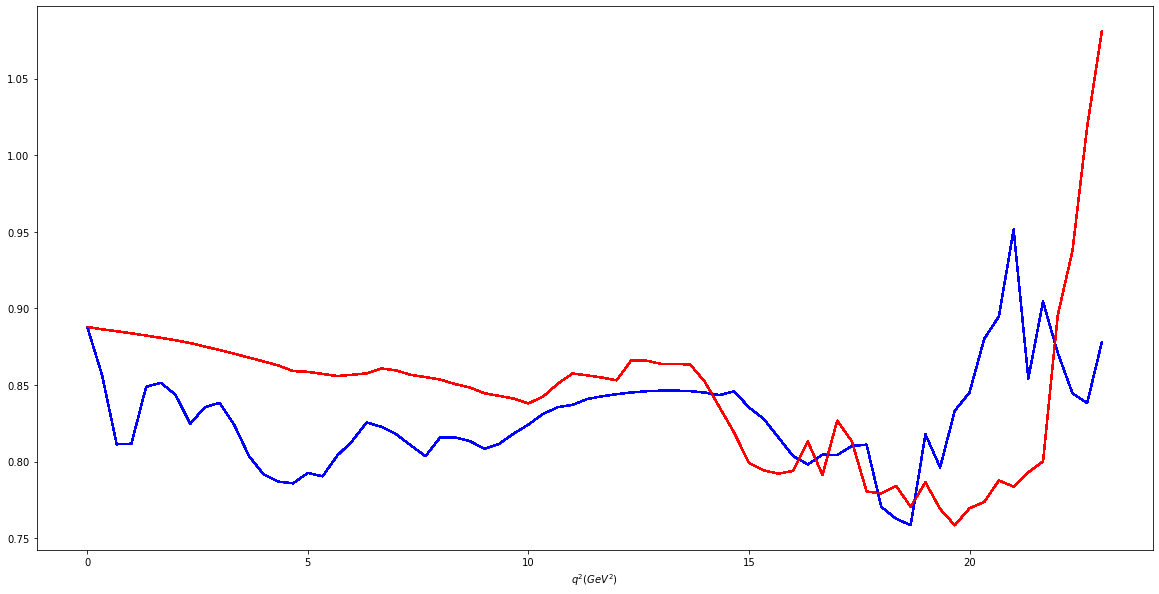

In [45]:
plt.rcParams["figure.figsize"] = (20,10)
q2rangetoplot = np.linspace(0,23,70)
ffstoplot = ffs_from_input_q2(inputq2[0],inputq2[1])
inputffs = np.append(ffstoplot[0][1],ffstoplot[1][1])
plt.xlabel("$q^2 (GeV^2)$")
#plt.ylabel("Form factor")
for i in range(np.shape(coarray_alt)[1]):
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[:nzero,i],0) for q2 in q2rangetoplot],color = "blue",alpha=0.005)
    #plt.plot(q2rangetoplot, [zfunction(q2,coarray[nzero:nzero+nplus,i],1) for q2 in q2rangetoplot],color = "orange",alpha=0.005)
    plt.plot(q2rangetoplot,[abs((sorted_ffarray_alt[0,q2,sigmabelow_alt]-sorted_ffarray_alt[0,q2,sigmaabove_alt])/(sorted_ffarray[0,q2,sigmabelow]-sorted_ffarray[0,q2,sigmaabove])) for q2 in range(len(q2rangetoplot))],color = "blue",label = "alt fit")
    plt.plot(q2rangetoplot,[abs((sorted_ffarray_alt[1,q2,sigmabelow_alt]-sorted_ffarray_alt[1,q2,sigmaabove_alt])/(sorted_ffarray[1,q2,sigmabelow]-sorted_ffarray[1,q2,sigmaabove])) for q2 in range(len(q2rangetoplot))],color = "red",label = "alt fit")
plt.show()

In [46]:
print("coeff_squared = ",coeff_squared)

print("coeff_alt_squared = ",coeff_alt_squared)

print("z^2 term is ",f2_norm*coeff_alt_squared[0][2])
print("z term is ",f2_norm*coeff_alt_squared[0][2]*f2_b + f1_norm*coeff_alt_squared[0][1])
print("constant term is ",f0_norm*coeff_alt_squared[0][0] + f1_norm*coeff_alt_squared[0][1]*(-(sin_alpha)/alpha) + f2_norm*coeff_alt_squared[0][2]*f2_c)


coeff_squared =  [0.56804927 0.45228976 0.2919012  0.28161557 0.08596698 0.09050149
 0.0858996  0.17141868 0.12364113 0.25069535 0.28265256 0.17777758
 0.18990296 0.32969283 0.07249337 0.21538467 0.33162114 0.15178756
 0.08135461 0.12989739 0.07951395 0.34652431 0.07672812 0.15621685
 0.43645275 0.06942821 0.25106141 0.17299436 0.07867016 0.06974623
 0.38867044 0.20673244 0.41237419 0.38487942 0.09240696 0.15715481
 0.20844227 0.337616   0.19850145 0.08314853 0.34455369 0.11482835
 0.08888114 0.0987892  0.10940403 0.31257826 0.24495743 0.16656267
 0.18899911 0.16016933 0.18130343 0.36008106 0.1124692  0.08150194
 0.13231916 0.69599223 0.10117064 0.29674729 0.35049276 0.3627433
 0.12347183 0.07882352 0.07937443 0.38115364 0.48120017 0.12925402
 0.1618573  0.38315486 0.16761815 0.16038687 0.20408596 0.34255992
 0.12098366 0.14958298 0.30239363 0.20801751 0.08635136 0.10930844
 0.1335307  0.14604356 0.25668563 0.14822362 0.10608412 0.342354
 0.11026123 0.2392113  0.22487158 0.0999855  0.2

IndexError: invalid index to scalar variable.